# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Jiageng | Mi | Jiageng Mi, 1105 | 5h | 26% |
| Member 2: | Lucy | Boahen | Lucy Asantewaa Boahen, 1106 | 3h | 22% |
| Member 3: | Xinyue | Zhang | Xinyue Zhang,1107  | 3h | 26% |
| Member 4: | Yi | Wang | Nancy Yi Wang, 1108 | 3h | 26% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

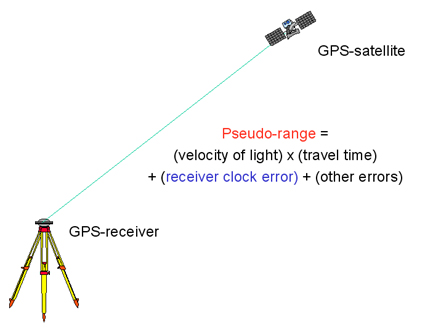

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 0.2: Read and parse data files

In [ ]:
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


In [ ]:
df_pseudorange = pd.read_excel('pseudoranges.xlsx')
df_sat_pos = pd.read_excel('satellite_position.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance
print(euclidean_norm(GroundTruth, sat_pos))

[22919735.50416796 20459891.58181501 22400334.25542599 22829138.20273155
 22342011.77899318 25646450.14718576 23814770.16593441 24311391.26510924
 21353638.3890343  24971604.82362354 20638980.11687546]


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

# Compute the sum of squared residuals between measured and predicted pseudoranges.
#Parameters:
     # r_pos: numpy array of shape (3,), the estimated receiver's position (x, y, z).
     # cdT: float, the clock offset (bias).
     # s_pos: numpy array of shape (n, 3), the satellites' coordinates.
     # pseudorange: numpy array of shape (n,), the measured pseudoranges.

    # Returns:
    # L: float, the sum of squared residuals (cost).
    # Predicted pseudoranges: geometric distance + clock offset
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT
    # Residuals: differences between observed and predicted pseudoranges
    residuals = pseudorange - predicted_pseudoranges
    # Calculate the sum of squared residuals
    L = np.sum(residuals**2)

    return L
print(cost_function(GroundTruth, 0, sat_pos, pseudorange))

218.11293249462665


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    #...
    grad = np.zeros(4)

    # Loop over each satellite position
    # predicted_pseudoranges = np.array([euclidean_norm(r_pos, s) for s in s_pos])
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos)
    for i in range(len(s_pos)):
        x_s, y_s, z_s = s_pos[i]
        r = predicted_pseudoranges[i] + cdT - pseudorange[i]
        grad[0] += 2 * r * (r_pos[0] - x_s) / predicted_pseudoranges[i]
        grad[1] += 2 * r * (r_pos[1] - y_s) / predicted_pseudoranges[i]
        grad[2] += 2 * r * (r_pos[2] - z_s) / predicted_pseudoranges[i]
        grad[3] += 2 * r

    return grad / len(s_pos)


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
arr_cost.clear()
arr_grad.clear()
arr_err.clear()
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors:", arr_err[-1])
print("Number of Steps:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient:", arr_grad[-1])

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46487283e+00]
Final Position Errors: [-3.06410407 -2.35577741  3.80056311]
Number of Steps: 3151
Final Cost Value: 6.197102213897188
Final Gradient: [ 4.69672781e-05  2.61704682e-04 -8.04332697e-04 -4.55997884e-04]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

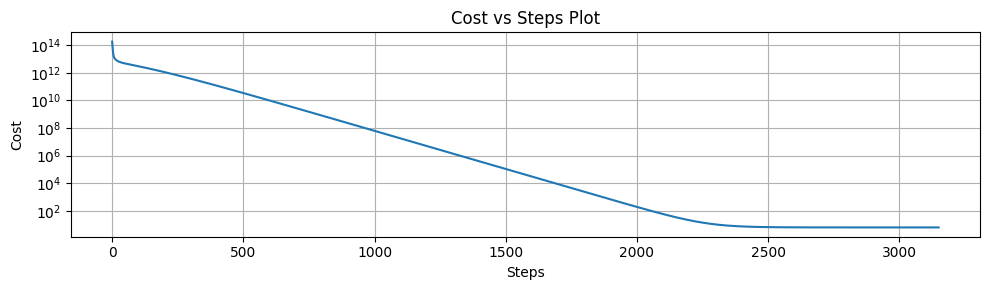

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

plt.semilogy(arr_cost)
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost vs Steps Plot")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Cost drops quickly to the 13th power of 10 at first, indicating the algorithm is approaching the optimal solution. And then steadily declines until it stabilizes around 10 after 2400 steps, showing convergence.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

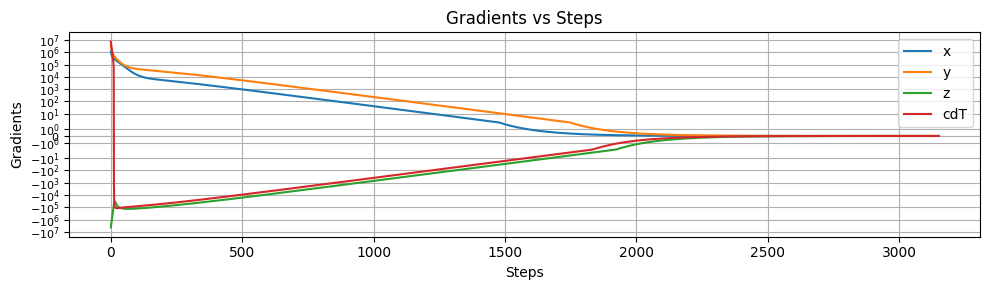

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

x_values = range(steps_count)
ax.plot(x_values, arr_grad)
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.legend(['x', 'y', 'z', 'cdT'], loc = 1)
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The gradients of x and y follow the same trend, steadily decreasing from the 6th power of 10 to near 0, while the trend of z is in the opposite direction of x and y, steadily increasing from the 5th power of -10 to near 0.
# The trend of the gradient of cdT, on the other hand, is a rapid decrease to the 5th power of -10 at the very beginning, followed by a steady increase in synchronization with z to near 0.
# All four parameters are in the stabilized after 2250steps.
# Positioning errors in x, y, and z axes decrease rapidly, each approaching zero, showing independent convergence in each axis.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

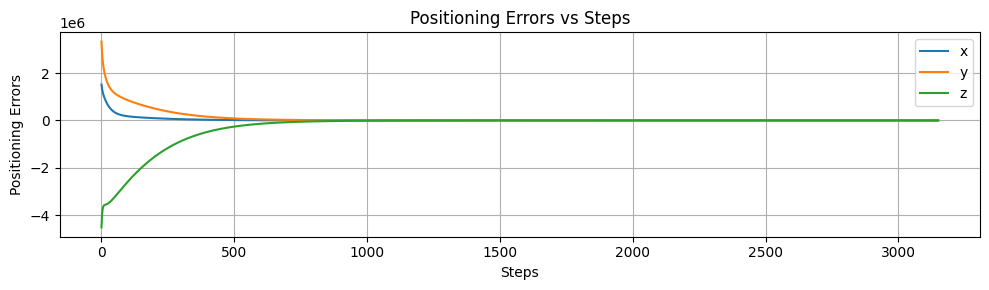

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...
x_values = range(steps_count)
ax.plot(x_values, arr_err)
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps')
ax.legend(['x', 'y', 'z'], loc = 1)
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# x, y and z experience a rapid decline or rise in different steps respectively, and then apprach 0 around 800 steps, showing the solution is close to accurate.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6)

# print the metrics
# ...
print("Optimized Parameters:", optimized_params_2)
print("Final Position Error:", np.linalg.norm(optimized_params_2[:3] - GroundTruth))
print("Number of Steps:", steps_count)
print("Final Cost:", arr_cost[-1] if arr_cost else "N/A")
print("Final Gradient:", arr_grad[-1] if arr_grad else "N/A")

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44938808e+00]
Final Position Error: 5.396690691680604
Number of Steps: 29782
Final Cost: 6.197818228887304
Final Gradient: [ 0.00014796  0.00082445 -0.00253389 -0.00143654]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=500000, tolerance=1e-6)

# print the metrics
# ...
print("Optimized Parameters:", optimized_params_3)
print("Final Position Error:", np.linalg.norm(optimized_params_3[:3] - GroundTruth))
print("Number of Steps:", steps_count)
print("Final Cost:", arr_cost[-1] if arr_cost else "N/A")
print("Final Gradient:", arr_grad[-1] if arr_grad else "N/A")

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40013170e+00]
Final Position Error: 5.321016702253749
Number of Steps: 279686
Final Cost: 6.20504954654009
Final Gradient: [ 0.00046981  0.00261779 -0.00804556 -0.00456126]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
Q1: With a learning rate of 0.01, the algorithm converges in 29782 steps, achieving a higher final error and cost. When the learning rate is reduced to 0.001, it takes 279686 steps to converge, which is slower but results in slightly lower final positioning error and cost. This shows that a lower learning rate leads to slower convergence but slightly more accurate results.

Q2: LSE directly computes the optimal parameters by solving a set of linear equations derived from the least-squares criterion. This means that, if a closed-form solution exists, it provides an exact answer in one step. Instead of a direct solution, Gradient Decent computes the gradient of the cost function and takes incremental steps (based on the learning rate) toward the minimum.

Since that, the Gradient Descent method required several iterations and careful tuning (such as adjusting the learning rate to avoid overshooting or zero steps), showing that it is more sensitive to parameter settings. The fact that steps can vary widely with learning rate adjustments demonstrates how Gradient Descent's performance and convergence depend on appropriate hyperparameter tuning, which is not a concern with LSE.

---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

result
 1        6157
-1        4898
Name: count, dtype: int64


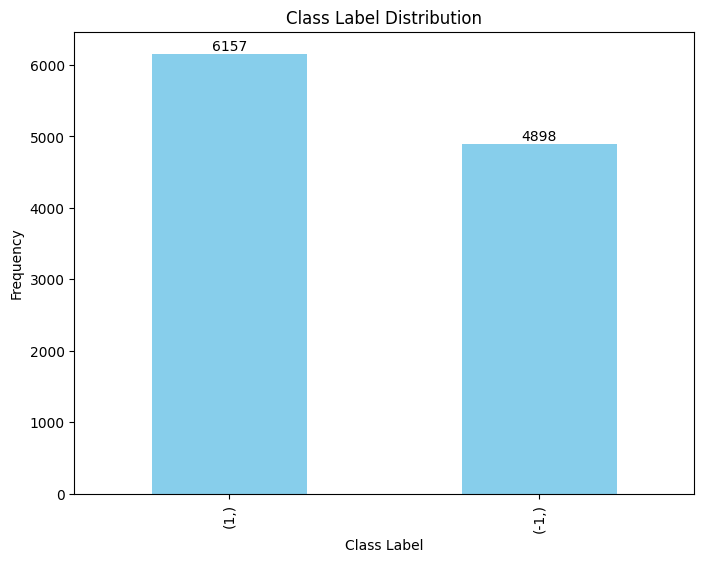

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()
print(class_counts)

# Display exact values for each bin in the histogram
plt.figure(figsize = (8,6))
class_counts.plot(kind = 'bar', color = 'skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Label Distribution')

for index, value in enumerate(class_counts):
  plt.text(index, value, str(value), ha = 'center', va = 'bottom')

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, test_size = 0.97, random_state = 42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

# STEP 3
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Instantiate model
LR = LogisticRegression(max_iter=2000)

# # Implement the model with X and y
# model_1 = LR.fit(X, y)

# # Implement the model with only first two columns of X and y
# model_2 = LR.fit(X.iloc[:, :2], y)

# # Implement the model with X_small and y_small
# model_3 = LR.fit(X_small, y_small)

# STEP 4
# define a function
def calculate_metrics(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    model = LR.fit(X_train, y_train)

    data_size = X.shape[0]
    train_samples = X_train.shape[0]
    test_samples = X_test.shape[0]
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))
    return data_size, train_samples, test_samples, train_accuracy, test_accuracy, log_loss_value

model_1_results = calculate_metrics(X, y.values.ravel())
model_2_results = calculate_metrics(X.iloc[:, :2], y.values.ravel())
model_3_results = calculate_metrics(X_small, y_small.values.ravel())

print("Model 1 Results:", model_1_results)
print("Model 2 Results:", model_2_results)
print("Model 3 Results:", model_3_results)

# STEP 5.1
results = pd.DataFrame(index=['Model 1', 'Model 2', 'Model 3'], columns=['Data size', 'Training samples', 'Testing samples', 'Training accuracy', 'Testing accuracy', 'Log loss'])

results.loc['Model 1'] = model_1_results
results.loc['Model 2'] = model_2_results
results.loc['Model 3'] = model_3_results

print(results)

Model 1 Results: (11055, 7738, 3317, 0.9322822434737659, 0.9228218269520652, 0.19032614464180939)
Model 2 Results: (11055, 7738, 3317, 0.5628069268544844, 0.5568284594513114, 0.6835732246498321)
Model 3 Results: (331, 231, 100, 0.9437229437229437, 0.91, 0.20036582213229728)
        Data size Training samples Testing samples Training accuracy  \
Model 1     11055             7738            3317          0.932282   
Model 2     11055             7738            3317          0.562807   
Model 3       331              231             100          0.943723   

        Testing accuracy  Log loss  
Model 1         0.922822  0.190326  
Model 2         0.556828  0.683573  
Model 3             0.91  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap


In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---